<a href="https://colab.research.google.com/github/fecampos/examples/blob/main/Ro_copernicus_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip -q install basemap dask xgcm getpass xarray numpy
! pip -q install importlib-metadata==4.13.0
! pip -q install git+https://github.com/pydap/pydap.git
import matplotlib.pyplot as plt
import getpass
from xgcm import Grid
from xgcm.autogenerate import generate_grid_ds
%matplotlib inline
from mpl_toolkits.basemap import Basemap, cm, shiftgrid
import xarray as xr
import numpy as np

from dask.distributed import Client, LocalCluster
cluster = LocalCluster(n_workers=1, threads_per_worker=2)
client = Client(cluster)

ERROR: Could not find a version that satisfies the requirement getpass (from versions: none)
ERROR: No matching distribution found for getpass
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
USERNAME = 'fcampos'
DATASET_ID = 'cmems_mod_glo_phy_my_0.083_P1D-m'
PASSWORD = getpass.getpass('Enter your password: ')

Enter your password: ··········


In [3]:
def copernicusmarine_datastore(dataset, username, password):
    from pydap.client import open_url
    from pydap.cas.get_cookies import setup_session
    cas_url = 'https://cmems-cas.cls.fr/cas/login'
    session = setup_session(cas_url, username, password)
    session.cookies.set("CASTGC", session.cookies.get_dict()['CASTGC'])
    database = ['my', 'nrt']
    url = f'https://{database[0]}.cmems-du.eu/thredds/dodsC/{dataset}'
    try:
        data_store = xr.backends.PydapDataStore(open_url(url, session=session, user_charset='utf-8')) # needs PyDAP >= v3.3.0 see https://github.com/pydap/pydap/pull/223/commits 
    except:
        url = f'https://{database[1]}.cmems-du.eu/thredds/dodsC/{dataset}'
        data_store = xr.backends.PydapDataStore(open_url(url, session=session, user_charset='utf-8')) # needs PyDAP >= v3.3.0 see https://github.com/pydap/pydap/pull/223/commits
    return data_store

In [4]:
data_store = copernicusmarine_datastore(DATASET_ID, USERNAME, PASSWORD)
ds = xr.open_dataset(data_store)
ds = ds.isel(depth=0, time=0)
ds_full = generate_grid_ds(ds, {'Y':'latitude','X':'longitude'})
grid = Grid(ds_full, periodic=['X'])

In [5]:
dlong = grid.diff(ds_full.longitude, 'X', fill_value=np.nan)
dlonc = grid.diff(ds_full.longitude_left, 'X', fill_value=np.nan)
dlonc_wo_discontinuity = grid.diff(ds_full.longitude_left, 'X', fill_value=np.nan)
dlatg = grid.diff(ds_full.latitude, 'Y', boundary='fill', fill_value=np.nan)
dlatc = grid.diff(ds_full.latitude_left, 'Y', boundary='fill', fill_value=np.nan)

In [9]:
def dll_dist(dlon, dlat, lon, lat):
        distance_1deg_equator = 111000.0
        dx= np.cos(lat*np.pi/180)*dlon*distance_1deg_equator        
        dy = (dlat*(lon * 0) + 1) * distance_1deg_equator
        return dx, dy

ds_full.coords['dxg'], ds_full.coords['dyg'] = dll_dist(dlong, dlatg, ds_full.longitude, ds_full.latitude)
ds_full.coords['dxc'], ds_full.coords['dyc'] = dll_dist(dlonc, dlatc, ds_full.longitude, ds_full.latitude)
ds_full.coords['area_c'] = ds_full.dxc * ds_full.dyc

In [31]:
omega = 7.2921e-5
zeta = grid.interp(grid.diff(ds_full.vo, 'X', boundary="extend")/ds_full.dxg,axis=["X"])\
      -grid.interp(grid.diff(ds_full.uo, 'Y',boundary="fill")/ds_full.dyg, axis=["Y"],boundary="fill")
zeta=zeta/(2*omega*np.sin(np.pi*ds_full.latitude/180))

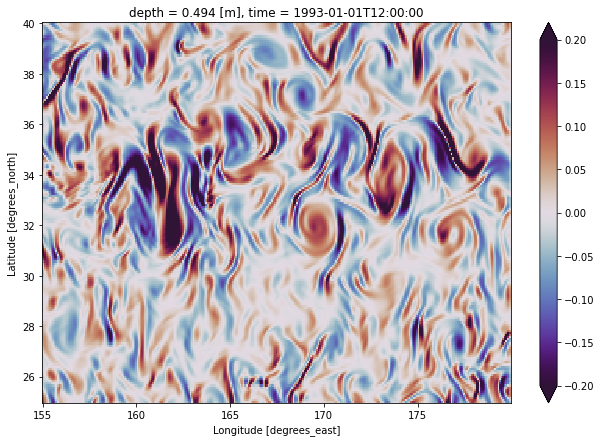

In [32]:
zeta.sel(longitude=slice(155,180), latitude= slice(25,40)).plot(vmin=-0.2,
                                                                   vmax=0.2,
                                                                   cmap="twilight_shifted",
                                                                   figsize=[10.5,7])

{155.0: ([<matplotlib.lines.Line2D at 0x7fda797c5d50>],
  [Text(155.025, 24.75, '155°E')]),
 160.0: ([<matplotlib.lines.Line2D at 0x7fda797d4310>],
  [Text(160.025, 24.75, '160°E')]),
 165.0: ([<matplotlib.lines.Line2D at 0x7fda797c5d10>],
  [Text(165.025, 24.75, '165°E')]),
 170.0: ([<matplotlib.lines.Line2D at 0x7fda797d42d0>],
  [Text(170.025, 24.75, '170°E')]),
 175.0: ([<matplotlib.lines.Line2D at 0x7fda797ccdd0>],
  [Text(175.025, 24.75, '175°E')]),
 180.0: ([<matplotlib.lines.Line2D at 0x7fda7ad280d0>],
  [Text(179.975, 24.75, '180°')])}

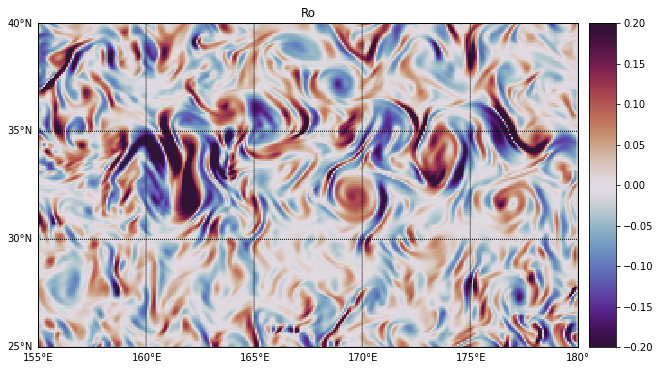

In [34]:
xx,yy = np.meshgrid(ds.longitude,ds.latitude)

fig = plt.figure(figsize=[8.5, 7], constrained_layout=True)
ax = fig.add_subplot()
m = Basemap(projection='cyl',llcrnrlat=25,urcrnrlat=40,\
            llcrnrlon=155,urcrnrlon=180,resolution='l')
pc = m.pcolor(xx, yy, zeta, vmin=-0.2, vmax=0.2, cmap='twilight_shifted', latlon=True)
plt.title("Ro")
m.drawmapboundary(fill_color='black')
#cb = m.colorbar(pc, location='bottom', label="m$^{2}$s$^{-2}$")
cb = m.colorbar(pc)

parallels = np.arange(0.,90,5)
m.drawparallels(parallels,labels=[True,False,True,False])
meridians = np.arange(10.,351.,5.)
m.drawmeridians(meridians,labels=[True,False,False,True])
#plt.savefig("alpha_"+str(uf[4][39:55])+".png", dpi=200)